In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import plotly.figure_factory as ff
from plotnine import *
from pyecharts.charts import Map
from pyecharts import options

# 导入数据

In [244]:
data_excel = pd.ExcelFile("../data/2023_MCM_Problem_Y_Boats.xlsx")
data_excel.sheet_names

['Monohulled Sailboats ', 'Catamarans']

合并excel表格的两个sheets并打上'Hull Num'标签。

In [245]:
df_mono = data_excel.parse(sheet_name='Monohulled Sailboats ')
df_mono.insert(loc=len(df_mono.columns), column='Hull Num',value='Monohulled Sailboats')
df_multi = data_excel.parse(sheet_name= 'Catamarans')
df_multi.insert(loc=len(df_multi.columns), column='Hull Num',value='Catamarans')
df = pd.concat([df_mono, df_multi])
df.rename(columns={'Length \n(ft)':'Length (ft)','Country/Region/State ':'Country/Region/State'}, inplace=True)
df['Year'] = df['Year'].astype('int64')
df

,Make,Variant,Length (ft),Geographic Region,Country/Region/State,Listing Price (USD),Year,Hull Num
0,Alubat,Ovni 395,41.0,Europe,France,267233,2005,Monohulled Sailboats
1,Bavaria,38 Cruiser,38.0,Europe,Croatia,75178,2005,Monohulled Sailboats
2,Bavaria,38 Cruiser,38.0,Europe,Croatia,66825,2005,Monohulled Sailboats
3,Bavaria,38 Cruiser,38.0,Europe,Croatia,54661,2005,Monohulled Sailboats
4,Bavaria,38 Cruiser,38.0,Europe,Croatia,53447,2005,Monohulled Sailboats
...,...,...,...,...,...,...,...,...
1140,Lagoon,50,48.0,Europe,Greece,788937,2019,Catamarans
1141,Lagoon,50,48.0,Europe,Greece,788937,2019,Catamarans
1142,Bali,5.4,55.5,Europe,Greece,1246325,2019,Catamarans
1143,Bali,5.4,55.5,Europe,Italy,811143,2019,Catamarans


# Data Cleaning

In [246]:
df_invalid_row = df[df.isnull().values == True]
df_invalid_row

,Make,Variant,Length (ft),Geographic Region,Country/Region/State,Listing Price (USD),Year,Hull Num
1586,Beneteau,Oceanis 54,54.0,USA,NaN,479805,2013,Monohulled Sailboats
1592,Delphia,46 cc,46.0,Europe,NaN,314606,2013,Monohulled Sailboats
1716,Bavaria,Cruiser 46,46.0,Europe,NaN,201640,2014,Monohulled Sailboats


注意到只在'Country/Region/State'这一列会出现NaN值，没有其他问题，这里选择剔除这几行，可以作为interesting findings看能不能通过机器学习的回归方法猜测这几艘船的'Country/Region/State'。

In [247]:
df_cleaned = df.dropna()

In [248]:
df[df['Make'] == 'Lagoon ']

,Make,Variant,Length (ft),Geographic Region,Country/Region/State,Listing Price (USD),Year,Hull Num
18,Lagoon,440,44.6,USA,Georgia,379000,2005,Catamarans
20,Lagoon,440,44.6,USA,Florida,320000,2005,Catamarans
88,Lagoon,380 S2,38.0,USA,Maryland,226900,2007,Catamarans
106,Lagoon,440,44.6,USA,Florida,294000,2007,Catamarans
114,Lagoon,570,56.0,Europe,France,705237,2007,Catamarans
150,Lagoon,420,41.0,USA,Florida,396000,2008,Catamarans
212,Lagoon,500,51.0,Europe,Greece,606875,2008,Catamarans
227,Lagoon,420,41.0,USA,Florida,280000,2009,Catamarans
240,Lagoon,500,51.0,Europe,Greece,546187,2009,Catamarans
249,Lagoon,400,39.0,Caribbean,Netherlands Antilles,275000,2010,Catamarans


发现有空格未去除，会导致后面多分了几个类，这里去掉

In [249]:
df_cleaned['Make'] = df_cleaned['Make'].str.strip()
df_cleaned['Variant'] = df_cleaned['Variant'].str.strip()
df_cleaned['Geographic Region'] = df_cleaned['Geographic Region'].str.strip()
df_cleaned['Country/Region/State'] = df_cleaned['Country/Region/State'].str.strip()

In [250]:
df_cleaned.to_excel('../data/2023_MCM_Problem_Y_Boats_cleaned.xlsx')

# 初步数据可视化和统计分析

In [251]:
df_cleaned['Make'].value_counts()
# df_cleaned['Country/Region/State'].value_counts()

Lagoon           682
Beneteau         515
Jeanneau         514
Bavaria          332
Hanse            179
                ... 
Nordship           2
Boreal             2
B-Yachts           2
J boats            1
HH Catamarans      1
Name: Make, Length: 82, dtype: int64

## 绘制饼图，看交易量和市场份额在不同厂商之间的分布
turnover: 交易量，market share: 市场份额

In [252]:
df_turnover = df_cleaned.groupby(['Make']).count()['Listing Price (USD)'] / df_cleaned['Make'].count()
small_turnover = df_turnover[df_turnover < 0.03].sum()
df_turnover = df_turnover[df_turnover >= 0.03]
df_turnover['Others'] = small_turnover
monopliers = df_turnover.keys()[:7]
monopliers

Index(['Bavaria', 'Beneteau', 'Dufour', 'Fountaine Pajot', 'Hanse', 'Jeanneau',
       'Lagoon'],
      dtype='object', name='Make')

In [253]:
df_market_share = df_cleaned.groupby(['Make']).sum()['Listing Price (USD)'] / df_cleaned['Listing Price (USD)'].sum()
small_market_share = df_market_share[df_market_share < 0.03].sum()
df_market_share = df_market_share[df_market_share >= 0.03]
df_market_share['Others'] = small_market_share

<AxesSubplot:ylabel='Turnover'>

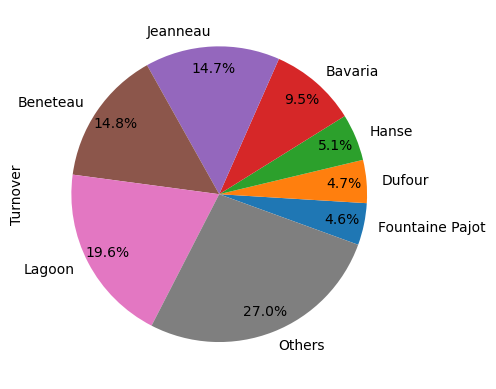

In [254]:
df_turnover.sort_values().plot.pie(autopct = '%1.1f%%',label='Turnover',startangle=-20,pctdistance = 0.85)

<AxesSubplot:ylabel='Market Share'>

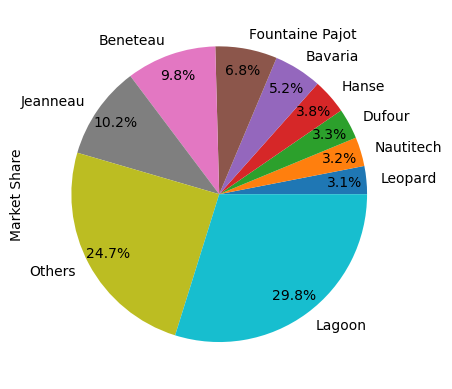

In [255]:
df_market_share.sort_values().plot.pie(autopct = '%1.1f%%',label='Market Share',startangle=0,pctdistance = 0.85)

## 绘制饼图，看交易量和市场份额在不同地区之间的分布

In [256]:
df_turnover = df_cleaned.groupby(['Country/Region/State']).count()['Listing Price (USD)'] / df_cleaned['Country/Region/State'].count()
small_turnover = df_turnover[df_turnover < 0.03].sum()
df_turnover = df_turnover[df_turnover >= 0.03]
df_turnover['Others'] = small_turnover
big_market = df_turnover.keys()[:9]

In [257]:
df_market_share = df_cleaned.groupby(['Country/Region/State']).sum()['Listing Price (USD)'] / df_cleaned['Listing Price (USD)'].sum()
small_market_share = df_market_share[df_market_share < 0.03].sum()
df_market_share = df_market_share[df_market_share >= 0.03]
df_market_share['Others'] = small_market_share

<AxesSubplot:ylabel='Turnover'>

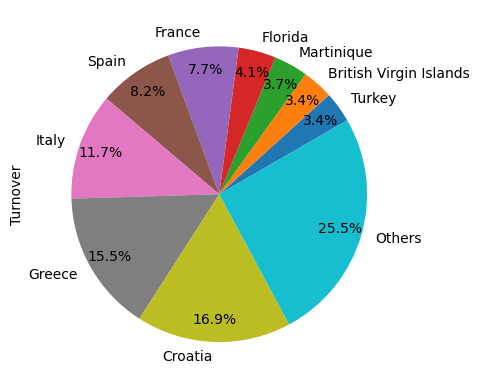

In [258]:
df_turnover.sort_values().plot.pie(autopct = '%1.1f%%',label='Turnover',startangle=30,pctdistance = 0.85)

<AxesSubplot:ylabel='Market Share'>

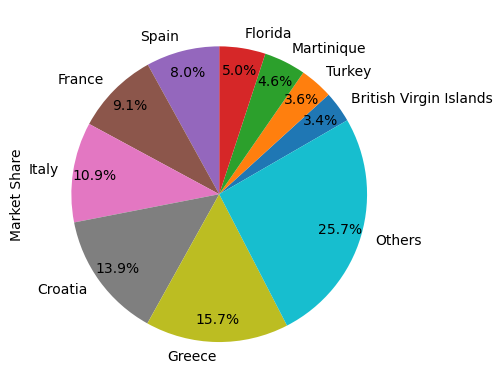

In [259]:
df_market_share.sort_values().plot.pie(autopct = '%1.1f%%',label='Market Share',startangle=30,pctdistance = 0.85)

## 绘制散点图：验证Listing Price和Length的正相关关系

In [260]:
r = pearsonr(df_cleaned['Length (ft)'],df_cleaned['Listing Price (USD)'])
print("pearson corr: ", r[0])
print("p-value: ", r[1])

pearson corr:  0.3689207021323563
p-value:  6.556675102450175e-113


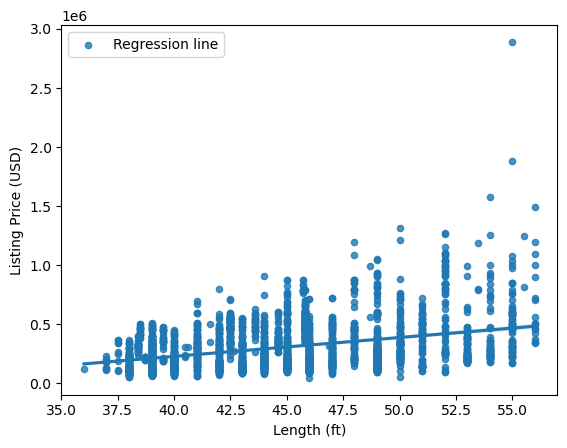

In [261]:
sns.regplot(data=df_cleaned,x='Length (ft)',y='Listing Price (USD)', scatter=True, label='Regression line',scatter_kws={"s": 20})
plt.legend(loc='best')
plt.show()

## 绘制散点图：验证Listing Price和Year的正相关关系

In [262]:
r = pearsonr(df_cleaned['Year'],df_cleaned['Listing Price (USD)'])
print("pearson corr: ", r[0])
print("p-value: ", r[1])

pearson corr:  0.4735955213071081
p-value:  1.578675789733277e-194


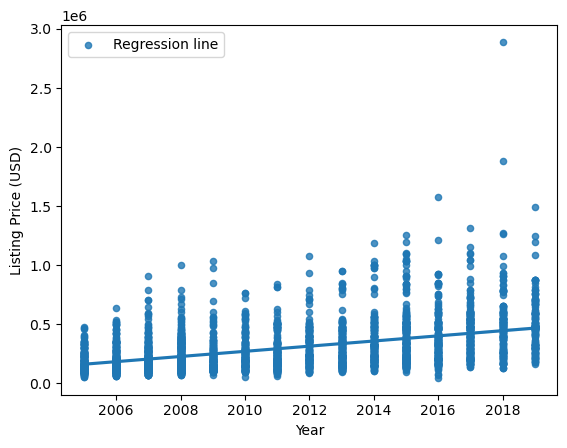

In [263]:
sns.regplot(data=df_cleaned,y='Listing Price (USD)',x='Year', scatter=True, label='Regression line',scatter_kws={"s": 20})
plt.legend(loc='best')
plt.show()

## 检查看看厂家售卖量和年份的关系

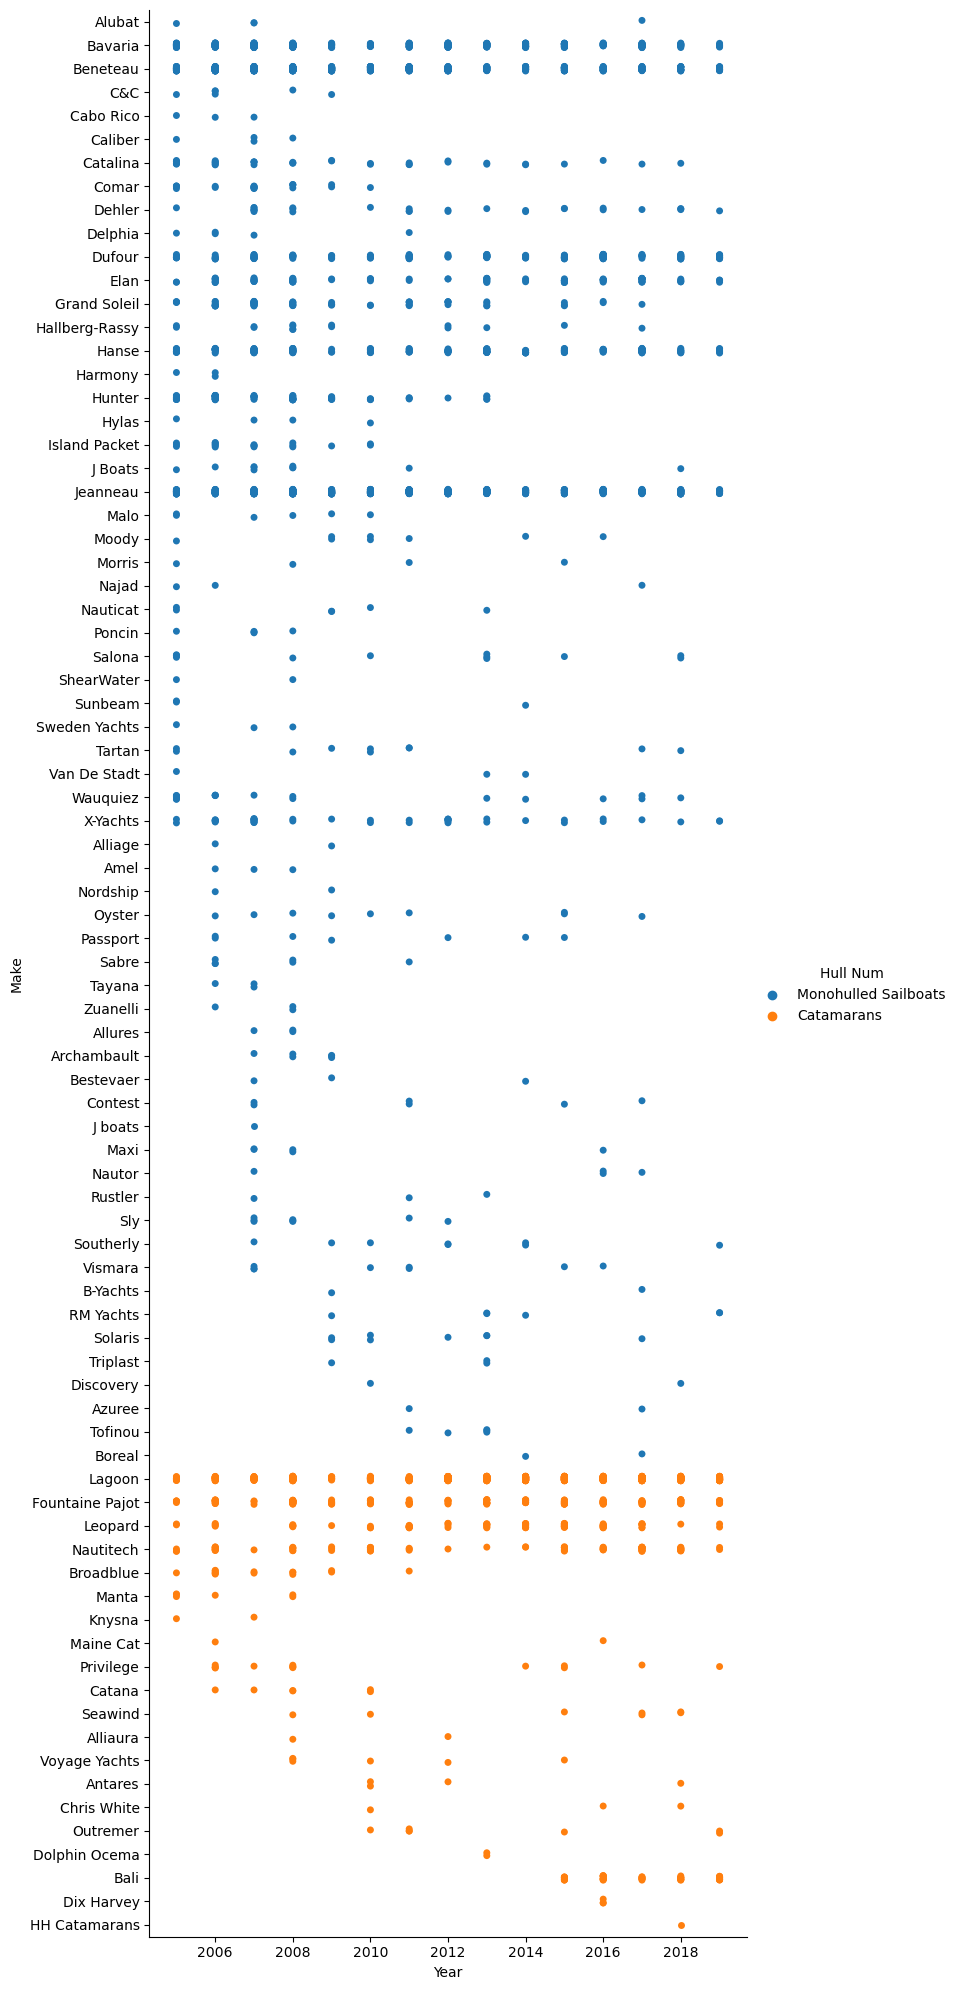

In [264]:
sns.catplot(data=df_cleaned,x='Year',y='Make',hue='Hull Num', height = 20,aspect=0.4)

## 看看不同地区购买两种不同的船型的量

<AxesSubplot:xlabel='count', ylabel='Country/Region/State'>

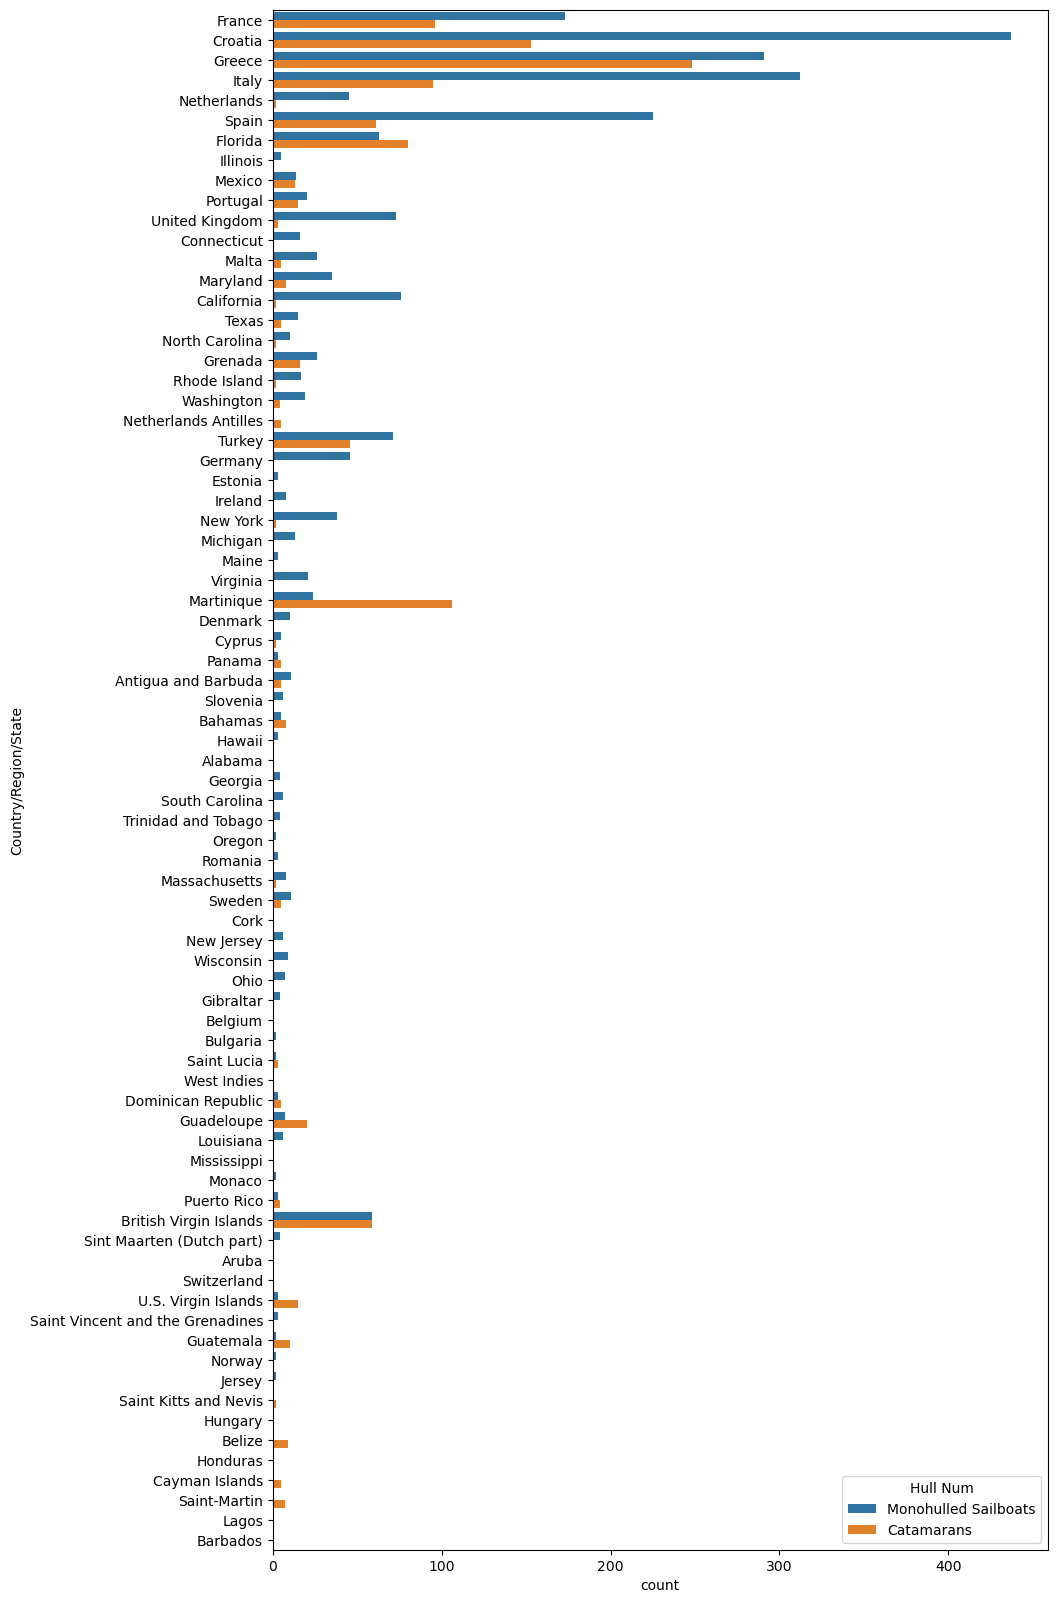

In [265]:
plt.figure(figsize=(10, 20))
sns.countplot(data=df_cleaned,y='Country/Region/State',hue='Hull Num')

## 看看垄断的厂家的主营地区都是哪里

<AxesSubplot:xlabel='count', ylabel='Make'>

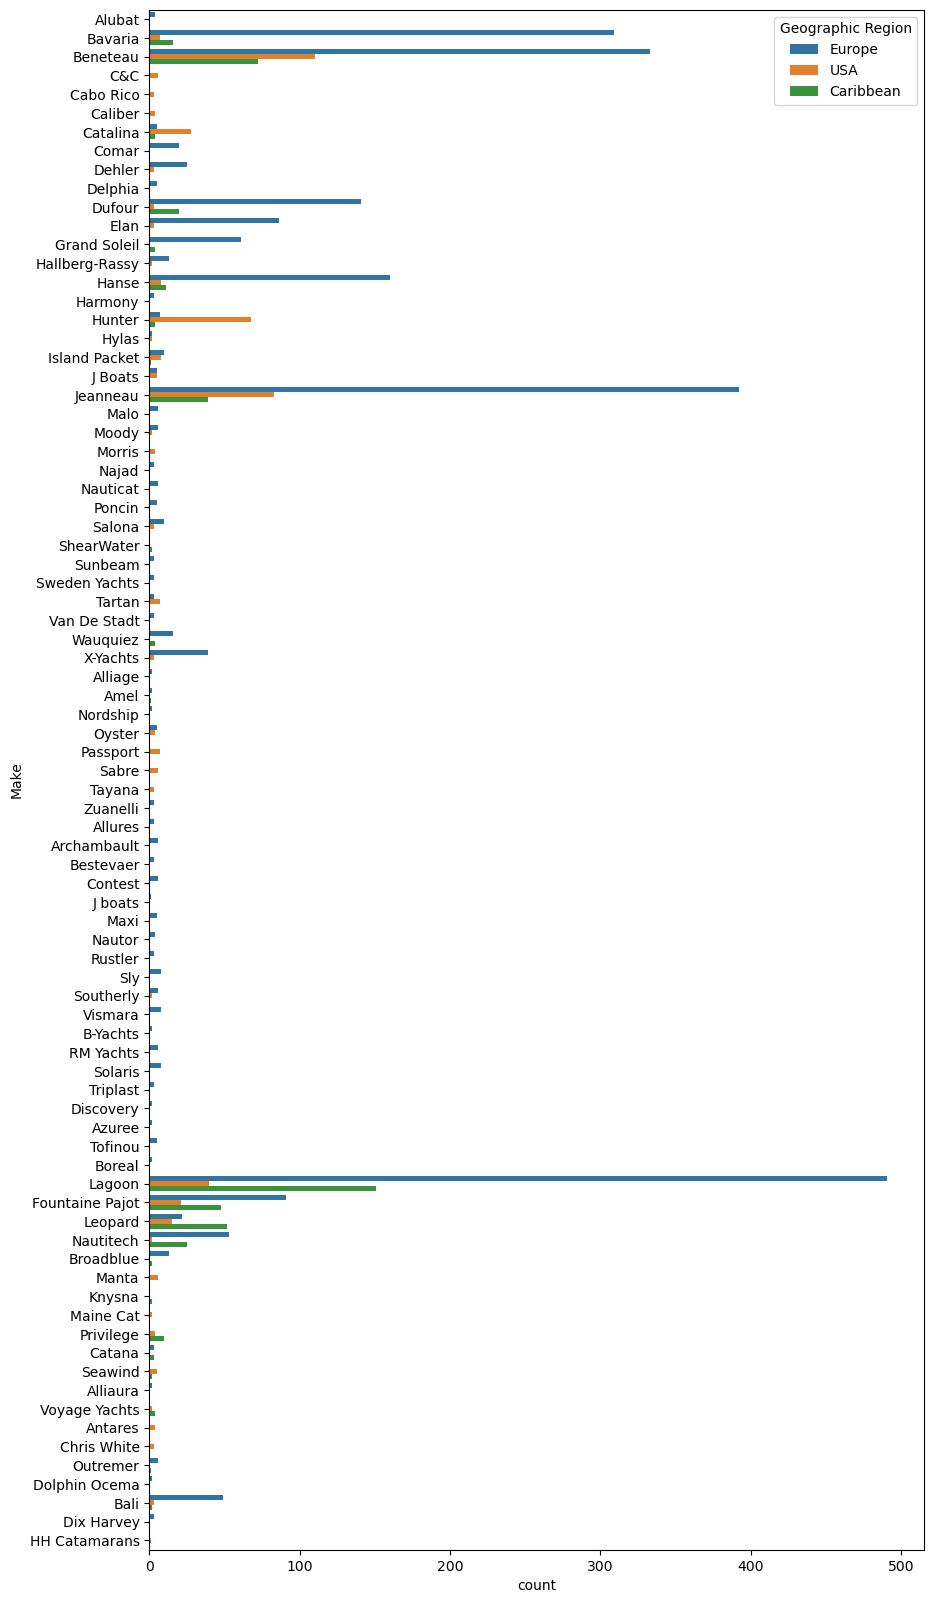

In [266]:
plt.figure(figsize=(10, 20))
sns.countplot(data=df_cleaned,y='Make',hue='Geographic Region')

# KDE plot: 看看Hull Num和Length的关系：
`分布是显著不同的`

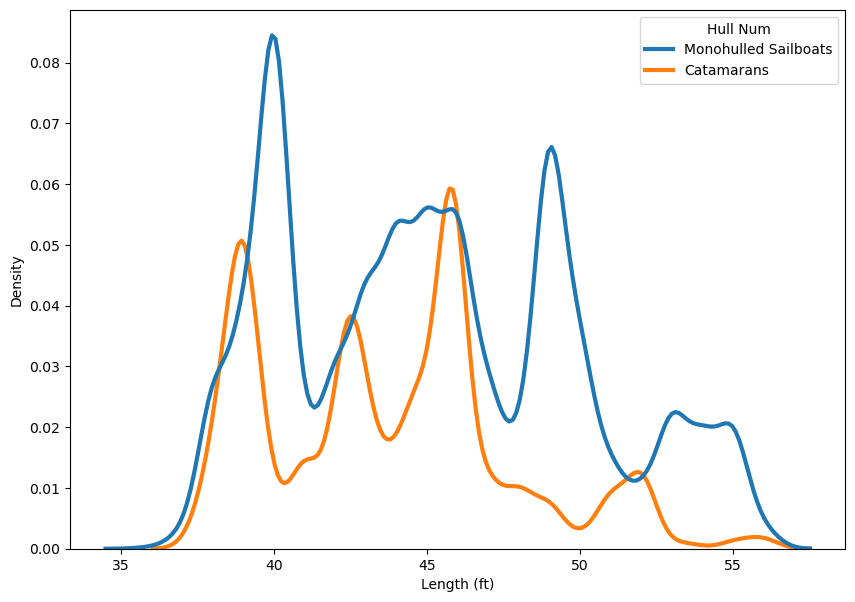

In [267]:
plt.figure(figsize=(10,7))
# sns.displot(data=df_cleaned, x='Length (ft)', hue='Hull Num',legend=False)
sns.kdeplot(data=df_cleaned, x='Length (ft)',hue='Hull Num',bw_adjust=.5,lw = 3)
plt.show()

In [268]:
s1 = df_cleaned['Length (ft)'][df_cleaned['Hull Num'] == 'Monohulled Sailboats']
s2 = df_cleaned['Length (ft)'][df_cleaned['Hull Num'] == 'Catamarans']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.2559246440665962, pvalue=8.962619165297294e-45)

## KDE plot：Geographic Region 和 Listing Price 的关系

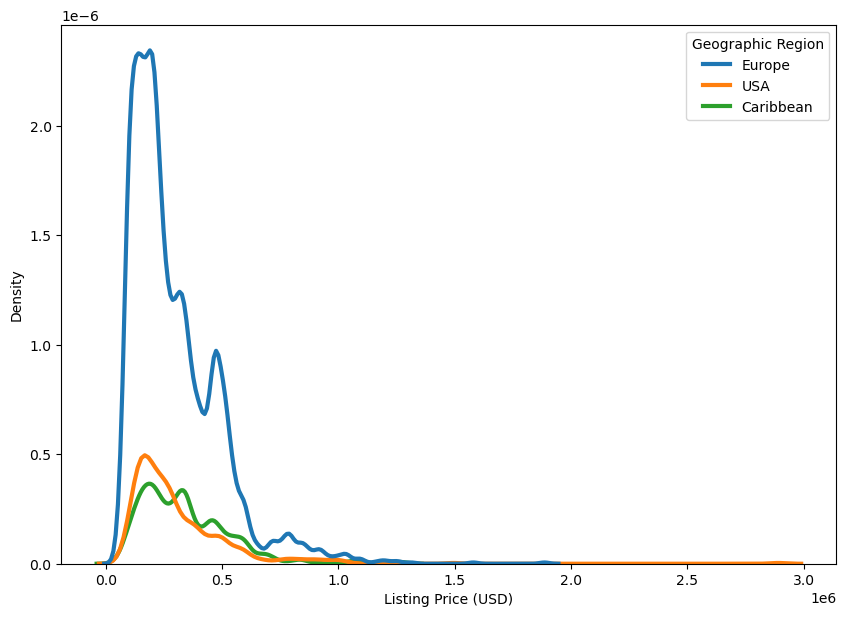

In [269]:
plt.figure(figsize=(10,7))
# sns.displot(data=df_kde, x='Listing Price (USD)', hue='Geographic Region',legend=False)
sns.kdeplot(data=df_cleaned, x='Listing Price (USD)',hue='Geographic Region',bw_adjust=.5,lw = 3)
plt.show()

### KS test:
|     |statistic|pvalue|
|:---:|:-------:|:----:|
|Europe vs. USA|0.07552315586748873|0.01722005795253017|
|Europe vs. Caribbean|0.14752914679385268|4.0166310555047366e-08|
|USA vs. Caribbean|0.17322154471544715|7.483248001932778e-07|

`均为显著不同的`

In [270]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Europe']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'USA']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.07552315586748873, pvalue=0.01722005795253017)

In [271]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Europe']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Caribbean']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.14752914679385268, pvalue=4.0166310555047366e-08)

In [272]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Caribbean']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'USA']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.17322154471544715, pvalue=7.483248001932778e-07)

## KDE plot：Hull Num 和 Listing Price 的关系

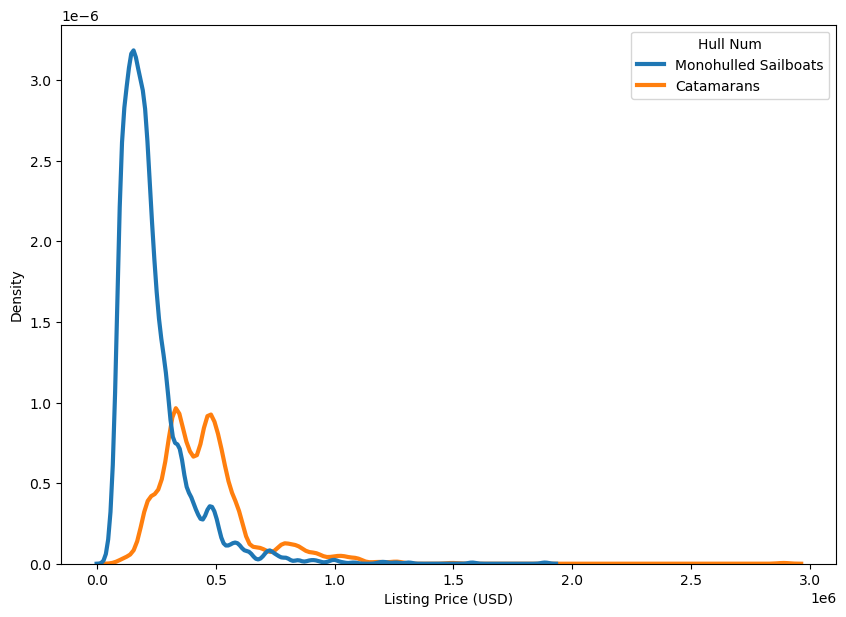

In [273]:
plt.figure(figsize=(10,7))
# sns.displot(data=df_kde, x='Listing Price (USD)', hue='Geographic Region',legend=False)
sns.kdeplot(data=df_cleaned, x='Listing Price (USD)',hue='Hull Num',bw_adjust=.5,lw = 3)
plt.show()

### KS test:
`两者的分布是显著不同的`

In [274]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Hull Num'] == 'Monohulled Sailboats']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Hull Num'] == 'Catamarans']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.6466352435108201, pvalue=8.529173023637341e-305)

In [278]:
value = [100,88, 99, 100, 69,90,18]
country = [('Croatia', 100),('France', 100),('Greece',100),('Italy', 100),('Martinique', 100),('Spain',100), ('Turkey',100)]
map_chart = Map()
map_chart.add('示例',country, maptype="world")
map_chart.set_global_opts(title_opts=options.TitleOpts(title="地图标题"), toolbox_opts=options.ToolboxOpts())
map_chart.width = "800px"  # 设置图表宽度
map_chart.render_notebook()

['定比','定比','定距','定距','定距','定比','定比','定比','定比','定比','定比','定类','定比','定比','定距','定距','定比','定距','定比','定比','定距','定比']